In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from google.colab import drive



In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [53]:
train_dir = "/content/drive/My Drive/cervix_cancer_data/train/"
test_dir = "/content/drive/My Drive/cervix_cancer_data/test2_resized/"
val_dir = "/content/drive/My Drive/cervix_cancer_data/val/"
data_dir = "/content/drive/My Drive/cervix_cancer_data/"




In [4]:
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': val_transforms,
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


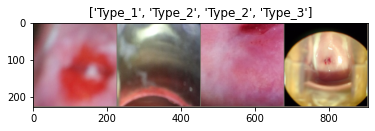

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # По всем данным.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Оптимизируется только последний слой
optimizer_conv = optim.AdamW(model.fc.parameters(), lr=0.001)

In [13]:
model = train_model(model, criterion, optimizer_conv, num_epochs=60)

Epoch 0/59
----------
train Loss: 1.1489 Acc: 0.4297
val Loss: 0.9685 Acc: 0.5249

Epoch 1/59
----------
train Loss: 1.0872 Acc: 0.4633
val Loss: 0.9749 Acc: 0.5107

Epoch 2/59
----------
train Loss: 1.1212 Acc: 0.4684
val Loss: 1.0468 Acc: 0.4489

Epoch 3/59
----------
train Loss: 1.1810 Acc: 0.4491
val Loss: 0.9669 Acc: 0.5273

Epoch 4/59
----------
train Loss: 1.0820 Acc: 0.4735
val Loss: 0.9911 Acc: 0.5273

Epoch 5/59
----------
train Loss: 1.0720 Acc: 0.4654
val Loss: 0.9461 Acc: 0.5416

Epoch 6/59
----------
train Loss: 1.0629 Acc: 0.4990
val Loss: 1.3756 Acc: 0.4798

Epoch 7/59
----------
train Loss: 1.1724 Acc: 0.4674
val Loss: 1.0945 Acc: 0.5416

Epoch 8/59
----------
train Loss: 1.0475 Acc: 0.4888
val Loss: 1.0554 Acc: 0.5012

Epoch 9/59
----------
train Loss: 1.0540 Acc: 0.5010
val Loss: 1.2523 Acc: 0.3895

Epoch 10/59
----------
train Loss: 1.0598 Acc: 0.5092
val Loss: 1.0611 Acc: 0.5154

Epoch 11/59
----------
train Loss: 1.0744 Acc: 0.4857
val Loss: 1.1172 Acc: 0.4133

Ep

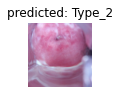

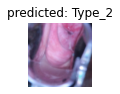

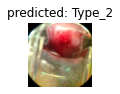

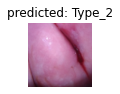

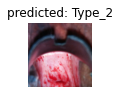

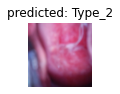

In [14]:
visualize_model(model)

plt.ioff()
plt.show()

In [73]:
test_image_data_result = pd.DataFrame(columns=["image_name", *class_names])
test_image_data_result

,image_name,Type_1,Type_2,Type_3


In [74]:
sigmoid_func = nn.Sigmoid()

In [75]:
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [76]:
len(os.listdir(test_dir))


4018

In [77]:
for image_name in os.listdir(test_dir):
    test_image = Image.open("".join((test_dir, image_name)))
    
    test_image = test_image.convert(mode='RGB')
    test_image = test_transforms(test_image)
    test_image = test_image.unsqueeze(0)
    
    test_output = model(test_image.cuda())
    
    test_output = sigmoid_func(test_output)
    test_output = test_output.flatten(0)

    test_output = test_output.tolist()
    
    temp_dict = dict(zip(class_names, test_output))
    temp_dict["image_name"] = image_name
            
    test_image_data_result.loc[len(test_image_data_result)] = temp_dict

In [78]:
test_image_data_result

,image_name,Type_1,Type_2,Type_3
0,13417.jpg,0.111868,0.698443,0.280202
1,11228.jpg,0.153751,0.834235,0.152647
2,12709.jpg,0.060780,0.795745,0.235967
3,11200.jpg,0.243205,0.720244,0.138139
4,11566.jpg,0.194130,0.772238,0.210611
...,...,...,...,...
4013,46.jpg,0.013930,0.662371,0.682629
4014,12513.jpg,0.058275,0.622408,0.448899
4015,10462.jpg,0.029269,0.459167,0.787505
4016,12275.jpg,0.035568,0.452757,0.758618


In [79]:
test_image_data_result.to_csv("submission6.csv", index=False)
# Скор 0.96815, у первого места в лидерборде 0.77, 
# последний получивший медаль 0.96.
# Уверен, можно получить лучше результаты, подбирая гиперпараметры

In [70]:
torch.save(model.state_dict(), "model1_60epochs")

KeyboardInterrupt: ignored